In [2]:
%matplotlib inline
import numpy as np
from math import sqrt, exp, log
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
## 市場資料
T = 1/2
rf1m, rf2m, rf3m, rf6m, rf12m = 0.001675, 0.00207,0.0023845,0.0035350,0.005881
fx_spot = 108
sp1m, sp2m, sp3m, sp6m, sp12m = -0.01325, -0.0425, -0.05855, -0.1221, -0.301
y_barrier = 105
n_barrier = 110

fx_6m = fx_spot + sp6m # 6個月的遠期匯率
r6m = ((1+rf6m/2)*fx_6m/fx_spot - 1)*2
## Heston Model 參數
## 應該是要用交易的資料calibration，但這邊老師直接給

v0 = 0.0102401
kappa = 1.171979
theta = 0.0141483
rho = 0.128199
sigma = 0.336611

n = 180
nos = 100000 # number of simulation
xright = n+5

得到報酬:False


Text(0.5, 1.0, 'Volatility')

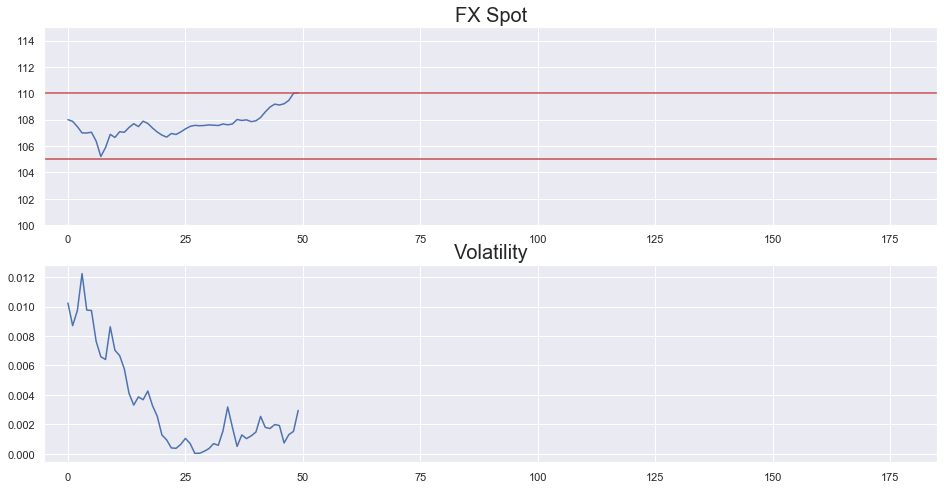

In [4]:
import numpy as np
from math import sqrt, exp, log

# 跑一次monte_carlo得一條路徑，看使否得到報酬
def monte_carlo(r,fx_spot,y_barrier,n_barrier,rf,v0,kappa,theta,rho,sigma,n,T,seed=None):
    
    ## 如果有指定隨機種子則用指定的，否則隨機指派本次模擬的隨機種子
    if seed == None:
        seed = np.random.randint(100000)
    np.random.seed = seed
    
    ## 抽樣
    zero_cov_rand = np.random.normal(size=(n,2)) #抽零相關的樣本
    cov_matrix = np.array([[1,rho],[rho,1]]) #共變異數矩陣
    cho_cov = np.linalg.cholesky(cov_matrix) # cholesky
    rho_cov_rand = zero_cov_rand.dot(cho_cov.T) #有相關性的brownian motion
    
    ## 模擬 S, V路徑，檢查是否得到報酬
    S = [fx_spot]
    V = [v0]
    dt = T/n
    touch_Y = False
    touch_N = False
    get_payoff = False
    for i in range(n):
        dS = (r-rf)*S[-1]*dt + sqrt(V[-1])*S[-1]*rho_cov_rand[i][0]*sqrt(dt)
        dV = kappa*(theta-V[-1])*dt + sigma*sqrt(V[-1])*rho_cov_rand[i][1]*sqrt(dt)
        V.append(abs(V[-1]+dV))
        S.append(S[-1]+dS)
        
    ## 檢查是否有碰到上下界
        if (S[-1] <= y_barrier) & (not touch_N):
            touch_Y = True
            break
        if (S[-1] >= n_barrier) & (not touch_Y):
            touch_N = True
            break
    
    ## 檢查上下界的狀況已決定是否得到報酬
    if touch_Y & (not touch_N):
        get_payoff = True
    
    return get_payoff,S,V

get_payoff, S, V = monte_carlo(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T)


print('得到報酬:{}'.format(get_payoff))
x = np.arange(len(S))  
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.xlim((-5, xright))
plt.ylim((100, 115))
plt.plot(x,S)
plt.axhline(105, color= 'r')
plt.axhline(110, color= 'r')
plt.title('FX Spot',size=20)
plt.subplot(212)
plt.xlim((-5, xright))
plt.plot(x,V)
plt.title('Volatility',size=20)

In [5]:
result_list = []
S_list = []
V_list = []

for i in range(nos):
    result,S,V = monte_carlo(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T)
    if result:
        result_list.append(1)
    else:
        result_list.append(0)
    S_list.append(S)
    V_list.append(V)
    if i % 10000 == 0:
        print("已經模擬{:^8d}次".format(i+1))

print('成功率 = {:>4f}%'.format(sum(result_list) / len(result_list)*100))
print("模擬結束")

已經模擬   1    次
已經模擬 10001  次
已經模擬 20001  次
已經模擬 30001  次
已經模擬 40001  次
已經模擬 50001  次
已經模擬 60001  次
已經模擬 70001  次
已經模擬 80001  次
已經模擬 90001  次
成功率 = 40.115000%
模擬結束


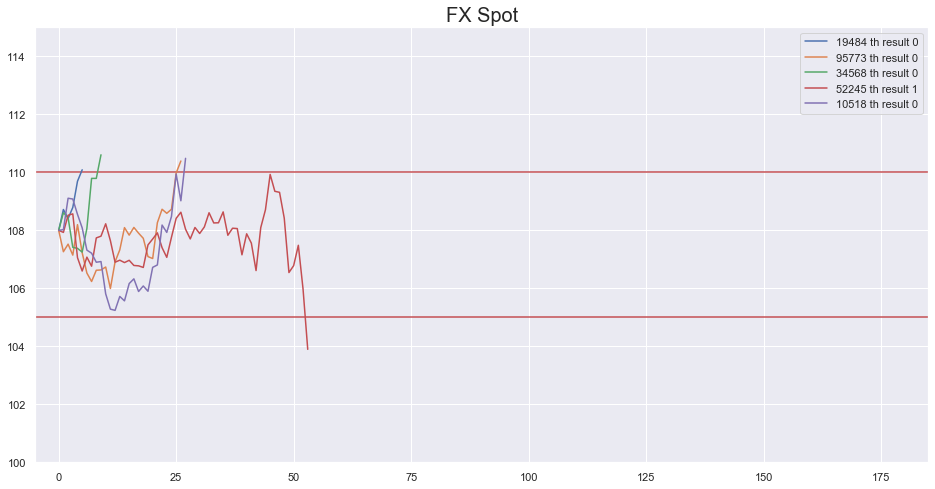

In [6]:
## 想做一個按鈕 可以選你要看幾次模擬結果
sample = np.random.randint(nos,size=5)
plt.figure(figsize=(16,8))
plt.axhline(105, color= 'r')
plt.axhline(110, color= 'r')
plt.title('FX Spot',size=20)
plt.xlim((-5, xright))
plt.ylim((100, 115))
for i in sample:
    x = np.arange(len(S_list[i]))
    plt.plot(x,S_list[i],label='{:^6d}th result {}'.format(i,result_list[i]))
plt.legend()

得到報酬:0


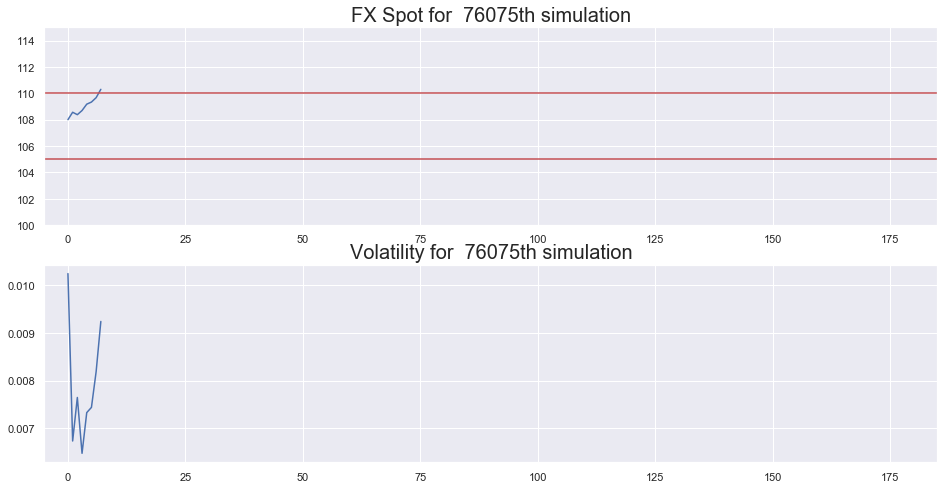

In [7]:
## 想做一個按鈕 可以選你要看第幾次模擬結果
i = np.random.randint(nos,size=1)[0]
S = S_list[i]
V = V_list[i]
x = np.arange(len(S))  
plt.figure(figsize=(16,8))
plt.subplot(211)
plt.xlim((-5, xright))
plt.ylim((100, 115))
plt.plot(x,S)
plt.axhline(105, color= 'r')
plt.axhline(110, color= 'r')
plt.title('FX Spot for {:>6d}th simulation'.format(i),size=20)
plt.subplot(212)
plt.xlim((-5, xright))
plt.plot(x,V)
plt.title('Volatility for {:>6d}th simulation'.format(i),size=20)
print('得到報酬:{}'.format(result_list[i]))

In [8]:
## 勝率及option價值
p = sum(result_list) / len(result_list)
(100*(1-p)+100*(1+0.03/2)*p)/(1+rf6m/2)

100.42422518199082

In [9]:

def op_value(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list):
    result_list = []
    S_list = []
    V_list = []
    
    for i in range(nos):
        seed = seed_list[i]
        result,S,V = monte_carlo(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,seed)
        if result:
            result_list.append(1)
        else:
            result_list.append(0)
        S_list.append(S)
        V_list.append(V)
    p = sum(result_list) / len(result_list)
    price = (100*(1-p)+100*(1+0.03/2)*p)/(1+rf6m/2)
    return price

In [10]:
seed_list = [None]*nos
op_value(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list)

100.42042190428418

In [11]:
def delta(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list):
    return (op_value(1.01*r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list)-op_value(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list))/0.01

In [12]:
delta_list = []
loop = 10
for i in range(loop):
    seed_list = np.random.randint(100000,size=nos)
    result = delta(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list)
    delta_list.append(result)
print("mean of delta : {}".format(np.array(delta_list).mean()))
print("std of delta : {}".format(np.array(delta_list).std()))

mean of delta : 0.0020962947984060065
std of delta : 0.3790080457518632


In [13]:
def gamma(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos):
    seed_list = np.random.randint(100000,size=nos)
    ans = (delta(1.01*r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list)-delta(0.99*r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list))/0.01
    return ans

In [14]:
gamma_list = []
loop = 10
for i in range(loop):
    result = gamma(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos)
    gamma_list.append(result)
print("mean of gamma : {}".format(np.array(gamma_list).mean()))
print("std of gamma : {}".format(np.array(gamma_list).std()))

KeyboardInterrupt: 

In [ ]:
def vega(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list):
    ans = (op_value(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0+0.0001,kappa,theta,rho,sigma,n,T,nos,seed_list) - op_value(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list))/0.0001
    return ans

In [ ]:
vega_list = []
loop = 10
for i in range(10):
    seed_list = np.random.randint(100000,size=100000)
    result = vega(r6m,fx_spot,y_barrier,n_barrier,rf6m,v0,kappa,theta,rho,sigma,n,T,nos,seed_list)
    vega_list.append(result)
print("mean of vega : {}".format(np.array(vega_list).mean()))
print("std of vega : {}".format(np.array(vega_list).std()))

In [ ]:
import pandas as pd
df = pd.DataFrame()
df['Delta'] = [np.array(delta_list).mean(),np.array(delta_list).std()]
df['Gamma'] = [np.array(gamma_list).mean(),np.array(gamma_list).std()]
df['Vega'] = [np.array(vega_list).mean(),np.array(vega_list).std()]
df.index = ['mean','std']
df.round(4)